In [1]:
import torch

# Check for CUDA!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Currently training on: {device}")

Currently training on: cuda


In [2]:
################################################################################
###########                      PARAMETERS                   ##################
################################################################################

BATCH_SIZE = 128 # used to be 512
WINDOW_SIZE = 512

# Trainning parameters
DROPOUT = 0.05
N_EPOCHS = 10
LEARNING_RATE = 3e-4

# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CHANNEL_SIZES = [32] * 3
KERNEL_SIZE = 16

In [3]:
################################################################################
###########                   Import Dataset(s)               ##################
################################################################################
from os import walk, path
from data.file_handler import filter_filenames, read_file
from data.processing import parse_str
from config import BASE, DATASET_DIR, DATA_REG, LABEL_REG
from torch.utils.data import DataLoader
from data.dataset import CustomDataset

# Get paths
filenames = next(walk(path.join(path.abspath('../'), "dataset")), (None, None, []))[2]  # extract all files from dataset folder
# file_paths = ["./dataset/data64QAM.txt", "./dataset/OSC_sync_291.txt", "./dataset/OSC_sync_292.txt", "./dataset/OSC_sync_293.txt"]
input_filenames = filter_filenames(filenames, DATA_REG) # filter the files, we only want output signals
input_filenames.sort()
label_filenames = filter_filenames(filenames, LABEL_REG)
label_filenames.sort()

array_data = []
array_labels = []

# We are specifally training on "OSC_sync_471.txt"
if input_filenames.count("OSC_sync_471.txt"):
  array_data = parse_str(
    read_file(path.join(path.abspath('../'), DATASET_DIR, "OSC_sync_471.txt"))
  )
else:
  print("OSC_sync_471.txt not found!")

if label_filenames.count("data64QAM.txt"):
  array_labels = parse_str(
    read_file(path.join(path.abspath('../'), DATASET_DIR, "data64QAM.txt")
    )
  )
else:
  print("data64QAM.txt not found!")

dataset = CustomDataset("../dataset", "OSC_sync_471.txt","data64QAM.txt", WINDOW_SIZE)

# Split into train and validation sets
train_size = int(0.6 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# dataset = CustomDataset_1D(array_data, array_labels, 255, train=True, train_ratio=0.6)
# dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# validation_dataset = CustomDataset_1D(
#   array_data, array_labels, 255, train=False, train_ratio=0.6
# )
# validation_dataloader = DataLoader(
#   validation_dataset, batch_size=512
# )

# train_count = 0
# flag = False
# print(f"Training dataloader iterations: {len(dataloader)}")
# print(f"Validation dataloader iterations: {len(validation_dataloader)}")
# for idx, data in enumerate(dataloader):
#     datas = data[0]
#     labels = data[1]
#     if not flag:
#       print("Data shape:", datas.shape)
#       print("Label shape:", labels.shape)
#       flag = True
#     train_count += datas.shape[0]
#     # break
# print(f"Training dataset count: {train_count}")
# test_count = 0
# flag = False
# for idx, data in enumerate(validation_dataloader):
#     datas = data[0]
#     labels = data[1]
#     if not flag:
#       print("Data shape:", datas.shape)
#       print("Label shape:", labels.shape)
#       flag = True
#     test_count += datas.shape[0]
#     # break
# print(f"Validation dataset count: {test_count}")
# print(f"Total count: {train_count + test_count}")


# Training

In [5]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

from nn.TCNN import BiTCN

model = BiTCN(
  INPUT_SIZE,
  OUTPUT_SIZE,
  CHANNEL_SIZES,
  KERNEL_SIZE,
  seq_len=WINDOW_SIZE,
  dropout=DROPOUT
)
model = model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
  model.parameters(),
  lr = LEARNING_RATE
)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

def train(model, device,train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for X_batch, y_batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        output = model(X_batch.to(device))
        loss = criterion(output, y_batch.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
    return average_loss

def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validation", leave=False):
            output = model(X_batch.to(device))
            loss = criterion(output, y_batch.to(device))
            total_loss += loss.item()
        average_loss = total_loss / len(val_loader)
    return average_loss

# Train the model
train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f"Starting epoch {epoch + 1}/{N_EPOCHS}")

    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = validate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{N_EPOCHS}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'BiTCN_best_model.pth')
        print(f"Saved model with validation loss: {best_val_loss:.4f}")


BiTCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): ParametrizedConv1d(
          1, 32, kernel_size=(16,), stride=(1,), padding=(15,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (chomp1): Chomp1D()
        (relu1): PReLU(num_parameters=1)
        (dropout1): Dropout(p=0.05, inplace=False)
        (conv2): ParametrizedConv1d(
          32, 32, kernel_size=(16,), stride=(1,), padding=(15,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (chomp2): Chomp1D()
        (relu2): PReLU(num_parameters=1)
        (dropout2): Dropout(p=0.05, inplace=False)
        (net): Sequential(
          (0): ParametrizedConv1d(
            1, 32, kernel_size=(16,), stride=(1,), padding=(15,)
            (parametrizations): Module

Epoch [1/10], Train Loss: 0.2034, Validation Loss: 0.0181
Saved model with validation loss: 0.0181
Starting epoch 2/10


Epoch [2/10], Train Loss: 0.0234, Validation Loss: 0.0155
Saved model with validation loss: 0.0155
Starting epoch 3/10


Epoch [3/10], Train Loss: 0.0200, Validation Loss: 0.0139
Saved model with validation loss: 0.0139
Starting epoch 4/10


Epoch [4/10], Train Loss: 0.0158, Validation Loss: 0.0122
Saved model with validation loss: 0.0122
Starting epoch 5/10


Epoch [5/10], Train Loss: 0.0152, Validation Loss: 0.0121
Saved model with validation loss: 0.0121
Starting epoch 6/10


Epoch [6/10], Train Loss: 0.0150, Validation Loss: 0.0114
Saved model with validation loss: 0.0114
Starting epoch 7/10


Epoch [7/10], Train Loss: 0.0142, Validation Loss: 0.0114
Saved model with validation loss: 0.0114
Starting epoch 8/10


Epoch [8/10], Train Loss: 0.0141, Validation Loss: 0.0115
Starting epoch 9/10


Epoch [9/10], Train Loss: 0.0141, Validation Loss: 0.0113
Saved model with validation loss: 0.0113
Starting epoch 10/10


Epoch [10/10], Train Loss: 0.0139, Validation Loss: 0.0114


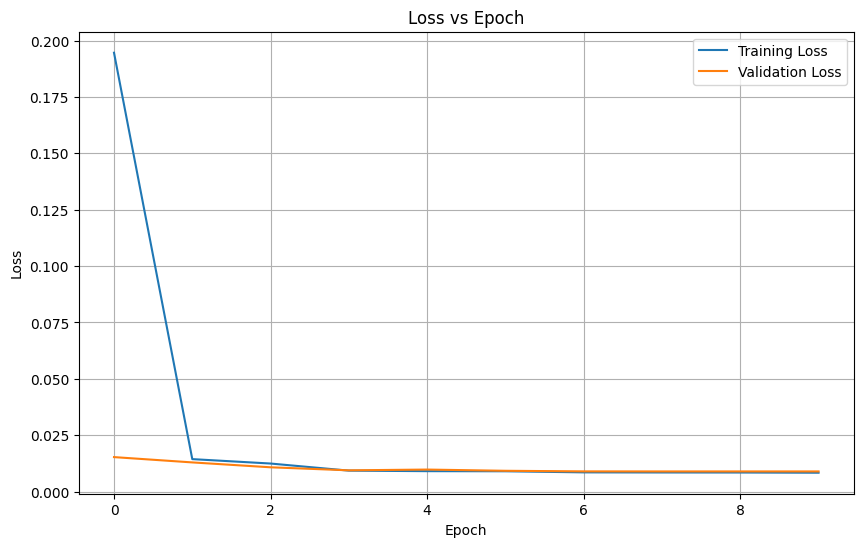

In [5]:
import matplotlib.pyplot as plt

# Plotting function
def plot_metrics(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot losses after training
plot_metrics(train_losses, val_losses)

In [6]:
def test_accuracy(model, device, test_loader, criterion):
    """
    Test the current model and compute accuracy or evaluation metrics.
    
    Args:
        model: The trained model.
        device: The computation device (e.g., 'cuda' or 'cpu').
        test_loader: DataLoader for the test dataset.
        criterion: The loss function for evaluation.

    Returns:
        average_loss: Average loss on the test dataset.
        accuracy: Accuracy for classification tasks, or None for regression tasks.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Testing", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()

            # Classification: Compute accuracy
            if len(y_batch.shape) == 1 or y_batch.size(1) == 1:  # Assumes binary or multiclass classification
                preds = output.argmax(dim=1) if output.ndim > 1 else (output > 0.5).long()
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
    
    average_loss = total_loss / len(test_loader)
    accuracy = correct / total if total > 0 else None

    print(f"Test Loss: {average_loss:.4f}")
    if accuracy is not None:
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return average_loss, accuracy

test_loss, test_accuracy = test_accuracy(model, device, val_loader, criterion)
print(test_loss, test_accuracy)

Test Loss: 0.0089
Test Accuracy: 0.00%
0.00892589084806973 0.0


# Running the Model

In [3]:
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import math

from data.dataset import CustomDataset
from nn.TCNN import BiTCN

model = BiTCN(
  INPUT_SIZE,
  OUTPUT_SIZE,
  CHANNEL_SIZES,
  KERNEL_SIZE,
  seq_len=WINDOW_SIZE,
  dropout=DROPOUT
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(
  torch.load("BiTCN_best_model.pth", map_location=torch.device(device))
)

dataset = CustomDataset("../dataset", "OSC_sync_471.txt","data64QAM.txt", WINDOW_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

predictions = []

def get_txt(model, device, data_loader):
    model.eval()
    output=[]
    with torch.no_grad():
        import time
        i = 0
        for X_batch, y_batch in tqdm(data_loader, desc="Validation", leave=False):
            start_time = time.time()  # 记录开始时间
            out = model(X_batch.to(device))
            end_time = time.time()  # 记录结束时间
            inference_time = end_time - start_time  # 计算推理时间
            # print(f"Inference Time: {inference_time} seconds")
            output.append(out.detach().cpu())
            outputs = torch.cat(output, dim=0)
            outputs_np = outputs.numpy()
            # i = i + 1
            # if i == 10:
            #   break
    return outputs_np.flatten()

predictions = get_txt(model, device, loader)
half_window = math.floor((WINDOW_SIZE - 1) // 2)
with open(r'../dataset/data64QAM.txt', 'r') as file:
    original_data = np.array([float(line.strip()) for line in file.readlines()])
diff = dataset.size - (len(predictions)  + half_window*2)
prefix = original_data[:half_window + diff]
suffix = original_data[-half_window:]
final_predictions = np.concatenate([prefix, predictions, suffix])
final_predictions = final_predictions.reshape(-1,1)

C:\Users\wjw_0\AppData\Local\Temp\ipykernel_19188\3468653221.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("BiTCN_best_model.pth", map_location=torch.devic

# Visualization

204800 204800 204800


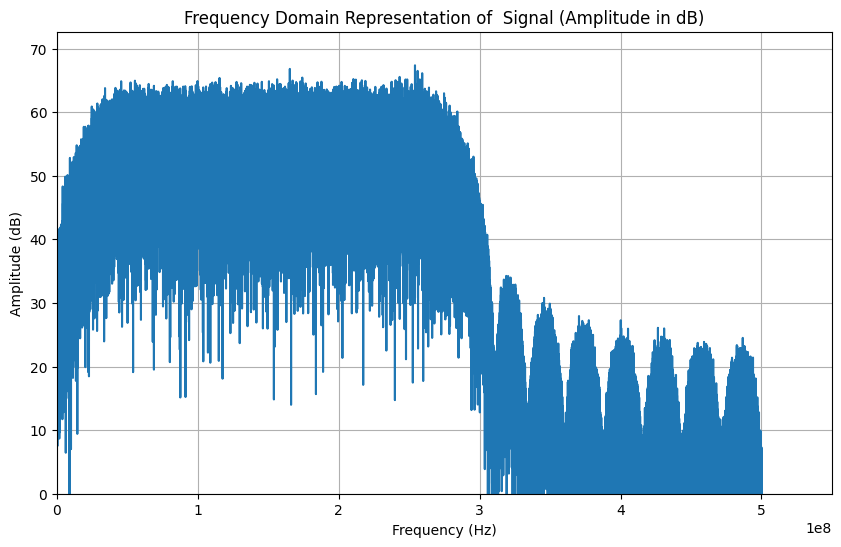

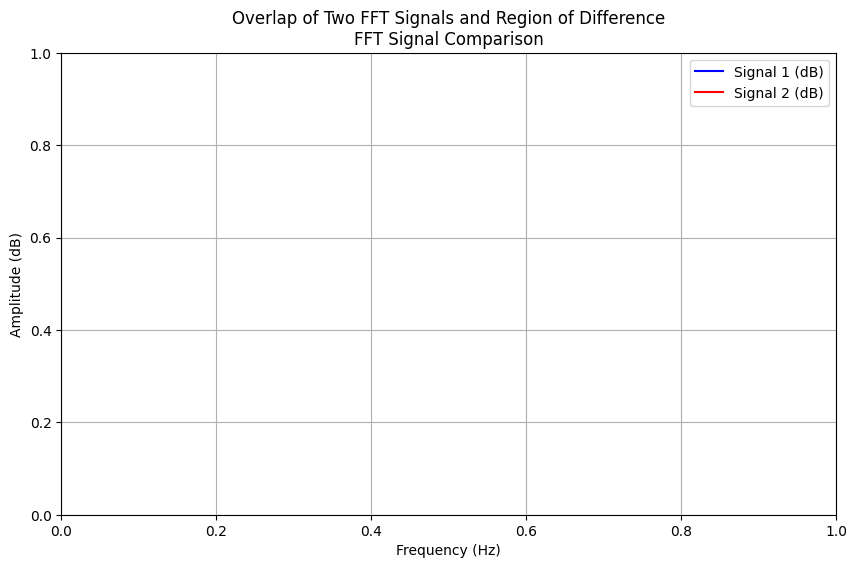

In [ ]:
from data.file_handler import read_file
from data.processing import parse_str
from visual.fft import fft, graph_fft, graph_fft_overlap

from os import path
import matplotlib.pyplot as plt
import numpy as np

folder_path = "../dataset"
data_file = "data64QAM.txt"
receieve_file = "OSC_sync_471.txt"

data_path = path.join(folder_path, data_file)
receive_path = path.join(folder_path, receieve_file)
dataset = parse_str(read_file(data_path))
receieve = parse_str(read_file(receive_path))

dataset = np.array(dataset).squeeze()
receieve = np.array(receieve).squeeze()

predictions = final_predictions.squeeze()

fft_signal_1, freqs_1 = fft(dataset)
fft_signal_2, freqs_2 = fft(receieve)
fft_signal_3, freqs_3 = fft(predictions)
print(len(fft_signal_1), len(fft_signal_2), len(final_predictions))

graph_fft(freqs_1, fft_signal_1, show_fig=False)
graph_fft(freqs_2, fft_signal_2, show_fig=False)
graph_fft(freqs_3, fft_signal_3, show_fig=False)
# graph_fft_overlap(freqs_1, fft_signal_1, freqs_2, fft_signal_2, title="FFT Signal Comparison")

plt.show()